In [1]:
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd
from aswan.constants import DEPOT_ROOT_ENV_VAR
from parquetranger import TableRepo
from tqdm.notebook import tqdm

from src.lichess import *
from src.lichess_decorate import export_dir, fixt_trepo, tournament_sample_path

In [10]:
dza = LichessDza(global_run=True)

2024-08-15 14:21:07 [warning  ] can't get module name, likely due to notebook call


In [5]:
dza.depot.pull(complete=True)

2024-08-15 13:18:45 [info     ] pulling 1 status contexts     
2024-08-15 13:18:46 [info     ] pulling 1 status dbs          
2024-08-15 13:18:46 [info     ] pulling 1 runs                


{'1723720255.5819435-285eeb550d2672e182f2'}

In [6]:
expandables = [
    "clock",
    "variant",
    "perf",
    "minRating",
    "maxRating",
    "minRatedGames",
    "schedule",
    "winner",
]

In [7]:
tournament_df = (
    pd.concat(
        map(
            lambda e: pd.DataFrame(e.content),
            dza.get_all_events(GetTournaments, only_latest=False),
        ),
        ignore_index=True,
    )
    .drop_duplicates(subset="id", ignore_index=True)
    .drop(["status"], axis=1)
    .reset_index(drop=True)
    .pipe(
        lambda df: pd.concat(
            [
                df.drop(expandables, axis=1),
                *[
                    pd.DataFrame(
                        df[c].fillna("").apply(lambda e: e or {}).tolist()
                    ).rename(columns=lambda s: f"{c}__{s}")
                    for c in expandables
                ],
            ],
            axis=1,
        )
    )
    .set_index("id")
    .assign(
        tournament_week=lambda df: df["startsAt"]
        .pipe(pd.to_datetime, unit="ms")
        .dt.to_period("W")
        .apply(lambda r: r.start_time.date().isoformat())
    )
)

2024-08-15 13:19:21 [info     ] pulling 0 status contexts     
2024-08-15 13:19:22 [info     ] pulling 0 status dbs          
2024-08-15 13:19:22 [info     ] pulling 0 runs                


<Axes: >

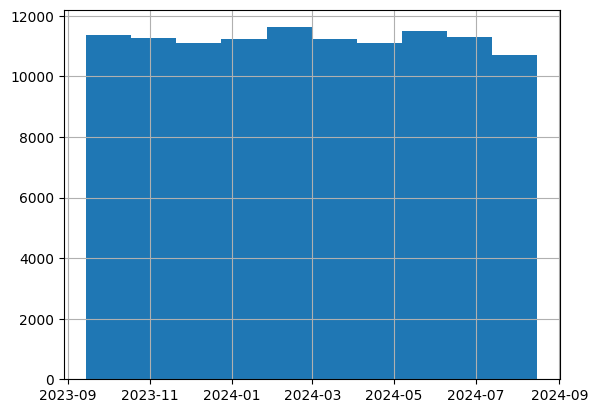

In [15]:
tournament_df["startsAt"].pipe(pd.to_datetime, unit="ms").hist()

In [16]:
tournament_df["nbPlayers"].describe()

count    112499.000000
mean        207.805589
std         227.477829
min           3.000000
25%          64.000000
50%         125.000000
75%         276.000000
max        2658.000000
Name: nbPlayers, dtype: float64

In [17]:
tournament_sample = tournament_df.loc[
    lambda df: (df["variant__key"] == "standard") & (df["nbPlayers"] > 350)
]

<Axes: >

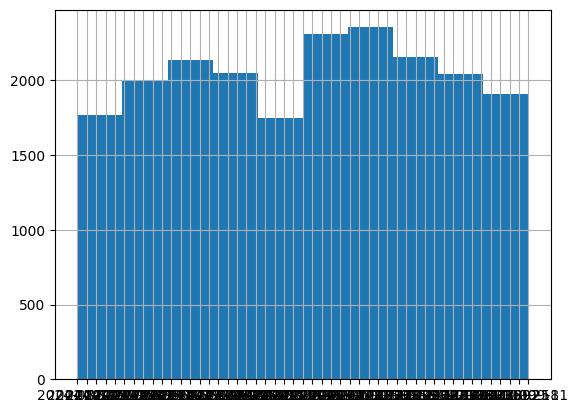

In [18]:
tournament_sample["tournament_week"].hist()

In [14]:
def extend_games(tour_k, pgn_string):
    meta_records = []
    for game_str in pgn_string.decode().strip().split("\n\n\n"):
        meta, moves = game_str.split("\n\n")

        meta_records.append(
            {
                "tournamentId": tour_k,
                "tournament_week": tournament_sample.loc[tour_k, "tournament_week"],
            }
            | dict(re.findall('\[([a-z|A-Z]+) "(.*)"\]', meta))
            | dict(
                zip(
                    ["WhiteStart", "BlackStart", "WhiteM1", "BlackM1"],
                    re.findall("\[%clk ([\d|\:]+)\]", moves)[:4],
                )
            )
        )
    return meta_records
    # game_trepo.extend(pd.DataFrame(meta_records))

In [15]:
fixt_trepo.purge()
all_recs = []


def _extend():
    fixt_trepo.extend(
        pd.DataFrame(all_recs).drop(
            ["WhiteTitle", "BlackTitle", "FEN", "SetUp"], axis=1, errors="ignore"
        )
    )

for el in tqdm(dza.get_all_events(GetTournamentGames)):
    tour_id = el.url.split("/")[-2]
    if tour_id in tournament_sample.index:
        all_recs += extend_games(tour_id, el.content)
    if len(all_recs) > 200_000:
        #_extend()
        pass
        all_recs = []
_extend()

0it [00:00, ?it/s]

In [23]:
tournament_sample.to_parquet(tournament_sample_path)

In [19]:
tournament_sample.to_csv(export_dir / "tournament-sample.csv.gz")